Α.

Ποια αρχιτεκτονική autoencoder πέτυχε το μικρότερο μέσο τετραγωνικό σφάλμα στα
δεδομένα εκπαίδευσης? Αυτή που χρησιμοποιήθηκε στην εργαστηριακή άσκηση ή αυτή που
εκπαιδεύσατε? Γιατί πιστεύετε ότι συνέβη αυτό?

In [1]:
# Hyperparameters
input_size = 28 # 28 x 28 = 784
batch_size = 64
learning_rate = 0.001
num_epochs = 20

In [3]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(root='./Mnist/training_set', train=True, transform=transform, download=True)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

test_dataset = datasets.MNIST(root='./Mnist/test_set', train=False, transform=transform, download=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, pin_memory=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 39.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.09MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.38MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.76MB/s]
100%|██████████| 9.91M/9.91M [00:00<00:00, 38.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.09MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.94MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.85MB/s]


In [5]:
import torch.nn as nn

# Define the autoencoder architecture separately in order to easily retrieve latent representations
class Autoencoder_V0(nn.Module):
  def __init__(self, input_size, latent_size):
    super(Autoencoder_V0, self).__init__()
    self.encoder = nn.Sequential(
        nn.Linear(input_size*input_size, 128),
        nn.ReLU(),
        nn.Linear(128, latent_size)
    )
    self.decoder = nn.Sequential(
        nn.Linear(latent_size, 128),
        nn.ReLU(),
        nn.Linear(128, input_size*input_size),
        nn.Sigmoid() # Sigmoid activation for output to be between 0 and 1
    )

  # Define forward pass as an encoding followed by decoding
  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

In [7]:
# Define the autoencoder architecture separately in order to easily retrieve latent representations
class Autoencoder_V1(nn.Module):
  def __init__(self, input_size, latent_size):
    super(Autoencoder_V1, self).__init__()
    self.encoder = nn.Sequential(
        nn.Linear(input_size*input_size, 128),
        nn.ReLU(),
        nn.Linear(128, 32),
        nn.ReLU(),
        nn.Linear(32, latent_size)
    )
    self.decoder = nn.Sequential(
        nn.Linear(latent_size, 32),
        nn.ReLU(),
        nn.Linear(32, 128),
        nn.ReLU(),
        nn.Linear(128, input_size*input_size),
        nn.Sigmoid() # Sigmoid activation for output to be between 0 and 1
    )

  # Define forward pass as an encoding followed by decoding
  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

In [9]:
import torch

# Function for training the autoencoder
def train_autoencoder(model: torch.nn.Module,
                      loss_fn: torch.nn.Module,
                      optimizer: torch.optim.Optimizer,
                      train_dataloader: torch.utils.data.DataLoader,
                      num_epochs: int):

  model.train() # Set training mode

  for epoch in range(num_epochs):
    for data in train_dataloader: # Iterates over batches of data from the training dataloader
      img, _ = data # Get an image
      img = img.view(img.size(0), -1).to(device) # Flatten each image into a 1D tensor and transfer image to device

      # 1. Forward pass
      output = model(img)

      # 2. Calculate loss
      loss = loss_fn(output, img) # Each input image is used as a label, to calculate the reconstruction error

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backwards
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

    # Print the loss for every epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

In [10]:
# Function for testing the autoencoder and visualizing the images
def test_autoencoder_plot_images(model: torch.nn.Module,
                                 test_dataloader: torch.utils.data.DataLoader,
                                 num_images: int,
                                 input_size: int,
                                 latent_size: int):

  model.eval() # Set evaluation mode

  break_iter = 1
  with torch.inference_mode(): # Deactivate gradient tracking
    for data in test_dataloader: # Iterates over batches of data from the test dataloader
      img, labels = data # Get an image
      img = img.view(img.size(0), -1).to(device) # Flatten each image into a 1D tensor and transfer image to device

      # Encode the input image and keep the representation in latent space
      encoded_imgs = model.encoder(img) # Representation in latent space, encoding of the image (3 numbers)
      rec_imgs = model.decoder(encoded_imgs) # Reconstructed image, 28 x 28

      # Visualize the original, encoded and reconstructed images
      plt.figure(figsize=(18, 18))
      for i in range(num_images):
        # Original images
        plt.subplot(num_images, num_images, i + 1)
        plt.imshow(img[i].cpu().numpy().reshape(input_size, input_size), cmap='gray') # Images to CPU and convert to Numpy for Matplotlib
        plt.title('Original')
        plt.axis('off')

        # For ploting in a matrix form and not a very big vector, for different latent sizes this may be changed
        if latent_size % 2 == 0: # latent size even number
          enc_img = encoded_imgs[i].cpu().numpy().reshape(-1, 4)
        else:
          enc_img = encoded_imgs[i].cpu().numpy().reshape(-1, 1)

        # Latent representation
        plt.subplot(num_images, num_images, i + 1 + num_images)
        plt.imshow(enc_img, cmap='hot') # Displaying latent vector as colors, encodings to CPU and convert to Numpy for Matplotlib
        plt.title('Encoded')
        plt.axis('off')

        # Recostructed images
        plt.subplot(num_images, num_images, i + 1 + 2*num_images)
        plt.imshow(rec_imgs[i].cpu().numpy().reshape(input_size, input_size), cmap='gray') # Images to CPU and convert to Numpy for Matplotlib
        plt.title('Recostructed')
        plt.axis('off')

      plt.show()
      break # Break after the first batch

In [12]:
RANDOM_SEED = 42 # Define RANDOM_SEED for reproducibility
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Define device

# For reproducability
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

# Define the autoencoder
latent_size_1 = 32
model_V0 = Autoencoder_V0(input_size, latent_size_1).to(device) # Transfer model to device

# Define loss function and optimizer
loss = nn.MSELoss() # MSE is the standard reconstruction-oriented loss
optimizer = torch.optim.Adam(model_V0.parameters(), lr=learning_rate)

In [13]:
# Train
train_autoencoder(model=model_V0, loss_fn=loss, optimizer=optimizer, train_dataloader=train_dataloader, num_epochs=num_epochs)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch [1/20], Loss: 0.0174


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch [2/20], Loss: 0.0121
Epoch [3/20], Loss: 0.0093
Epoch [4/20], Loss: 0.0109
Epoch [5/20], Loss: 0.0088
Epoch [6/20], Loss: 0.0074
Epoch [7/20], Loss: 0.0078
Epoch [8/20], Loss: 0.0090
Epoch [9/20], Loss: 0.0068
Epoch [10/20], Loss: 0.0079
Epoch [11/20], Loss: 0.0069
Epoch [12/20], Loss: 0.0066
Epoch [13/20], Loss: 0.0068
Epoch [14/20], Loss: 0.0075
Epoch [15/20], Loss: 0.0066
Epoch [16/20], Loss: 0.0077
Epoch [17/20], Loss: 0.0055
Epoch [18/20], Loss: 0.0069
Epoch [19/20], Loss: 0.0067
Epoch [20/20], Loss: 0.0069


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


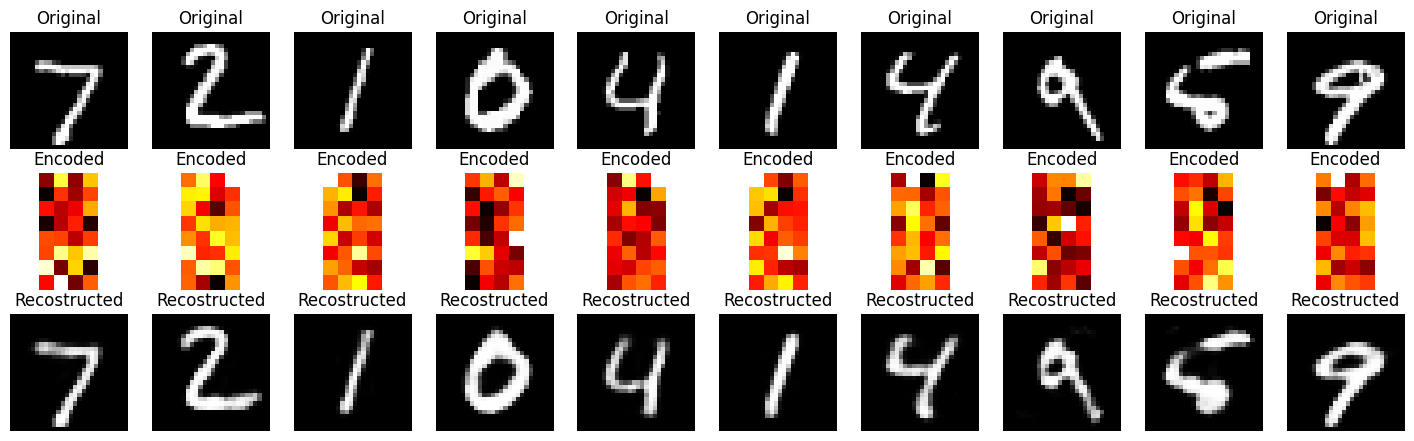

In [15]:
import matplotlib.pyplot as plt

# Test and visualize test images
test_autoencoder_plot_images(model=model_V0, test_dataloader=test_dataloader, num_images=10, input_size=input_size, latent_size=latent_size_1)

In [16]:
# For reproducability
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

# Define the new autoencoder
latent_size_2 = 3
model_V1 = Autoencoder_V1(input_size, latent_size_2).to(device) # Transfer model to device

# Define loss function and optimizer
loss = nn.MSELoss() # MSE is the standard reconstruction-oriented loss
optimizer = torch.optim.Adam(model_V1.parameters(), lr=learning_rate)

In [17]:
# Train
train_autoencoder(model=model_V1, loss_fn=loss, optimizer=optimizer, train_dataloader=train_dataloader, num_epochs=num_epochs)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch [1/20], Loss: 0.0449
Epoch [2/20], Loss: 0.0399
Epoch [3/20], Loss: 0.0349
Epoch [4/20], Loss: 0.0326
Epoch [5/20], Loss: 0.0384
Epoch [6/20], Loss: 0.0378
Epoch [7/20], Loss: 0.0325
Epoch [8/20], Loss: 0.0341
Epoch [9/20], Loss: 0.0341
Epoch [10/20], Loss: 0.0338
Epoch [11/20], Loss: 0.0357
Epoch [12/20], Loss: 0.0307
Epoch [13/20], Loss: 0.0360
Epoch [14/20], Loss: 0.0369
Epoch [15/20], Loss: 0.0343
Epoch [16/20], Loss: 0.0330
Epoch [17/20], Loss: 0.0340
Epoch [18/20], Loss: 0.0310
Epoch [19/20], Loss: 0.0357
Epoch [20/20], Loss: 0.0288


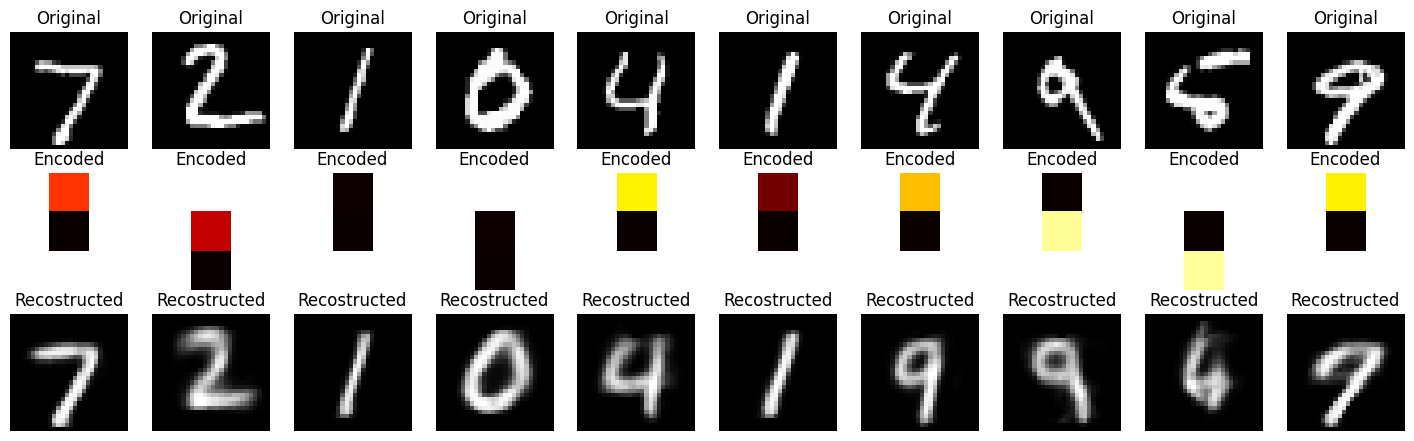

In [18]:
# Test and visualize test images
test_autoencoder_plot_images(model=model_V1, test_dataloader=test_dataloader, num_images=10, input_size=input_size, latent_size=latent_size_2)

Στην αρχιτεκτονική της εργαστηριακής άσκησης χρησιμοποιήθηκαν δύο κρυφά επίπεδα κωδικοποίησης με 128 και 32 νευρώνες, καθώς και δύο αντίστοιχα επίπεδα αποκωδικοποίησης. Το μέσο τετραγωνικό σφάλμα (MSE) στο τέλος της εκπαίδευσης ήταν 0.0073, τιμή που θεωρείται εξαιρετικά χαμηλή. Αυτό σημαίνει ότι η ανακατασκευασμένη έξοδος προσεγγίζει σε πολύ μεγάλο βαθμό την αρχική εικόνα εισόδου· στην πράξη, οι διαφορές μεταξύ αρχικής και ανακατασκευασμένης εικόνας είναι οπτικά δυσδιάκριτες. Ενδεικτικά παραδείγματα από το test set δείχνουν ότι οι περισσότερες εικόνες διατηρούν σχεδόν αναλλοίωτα τόσο το σχήμα όσο και την ένταση των ψηφίων.

Στη δεύτερη αρχιτεκτονική, που υλοποιήθηκε στο πλαίσιο της άσκησης, χρησιμοποιήθηκαν τρία επίπεδα κωδικοποίησης με 128, 32 και 3 νευρώνες και τρία αντίστοιχα επίπεδα αποκωδικοποίησης. Το τελικό MSE ήταν 0.0333, σαφώς μεγαλύτερο σε σχέση με την προηγούμενη περίπτωση. Η αύξηση αυτή υποδεικνύει ότι, όταν οι εικόνες συμπιέζονται σε λανθάνοντα χώρο μόλις 3 διαστάσεων, χάνεται σημαντικό μέρος της πληροφορίας που είναι κρίσιμη για την ποιοτική ανακατασκευή. Πράγματι, στις ανακατασκευασμένες εικόνες παρατηρούνται ορατές διαφορές: το λευκό χρώμα των ψηφίων είναι πιο «ξεθωριασμένο», τα περιγράμματα λιγότερο καθαρά και, σε ορισμένες περιπτώσεις, αλλάζει ακόμη και η αντιλαμβανόμενη κλάση του ψηφίου (π.χ. ένα 4 να μοιάζει πλέον περισσότερο με 9). Αυτό είναι αναμενόμενο, καθώς ψηφία με παρόμοιο σχήμα βρίσκονται κοντά στο latent space· αν ο χώρος αυτός είναι πολύ στενός (3D) και δεν επιτρέπει καλή διαχωρισιμότητα, μικρές διαφοροποιήσεις μπορεί να οδηγήσουν σε ανακατασκευές που αντιστοιχούν σε διαφορετική κλάση.

Συνοψίζοντας, η αρχιτεκτονική με bottleneck 32 διαστάσεων επιτυγχάνει σαφώς μικρότερο μέσο τετραγωνικό σφάλμα και πολύ πιο πιστές ανακατασκευές, επειδή οι 32 διαστάσεις επαρκούν για να διατηρηθεί η ουσιαστική πληροφορία της εικόνας. Αντίθετα, η αρχιτεκτονική με bottleneck 3 διαστάσεων επιβάλλει υπερβολικά ισχυρή συμπίεση, με αποτέλεσμα αυξημένη απώλεια πληροφορίας και χειρότερη ποιότητα ανακατασκευής

Β


Να απεικονίσετε κατάλληλα το σύνολο των εικόνων του training set όπως κωδικοποιούνται
στο latent space, με κατάλληλο χρώμα που να αντιστοιχεί στο label καθεμιάς. Κάνετε το ίδιο
και για τις εικόνες του test set. Διατηρούνται τα χαρακτηριστικά της κατανομής των
απεικονίσεων και στα δύο σύνολα? Σχολιάστε.


In [22]:
import numpy as np

coosTr = np.array([1,2,3])
lbTr = np.array([1])
cnt = 0
with torch.no_grad():
    for data in train_dataloader:
        imgs, labels = data
        imgs = imgs.view(imgs.size(0), -1).to(device)
        encoded_img = model_V1.encoder(imgs)
        coosTr = np.vstack([coosTr, encoded_img.cpu().numpy()])
        lbTr = np.append(lbTr, labels.cpu().numpy())
        cnt += 1

coosTr = np.delete(coosTr, 0, axis=0)
lbTr = np.delete(lbTr, 0)
Trsize = coosTr.shape[0]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [24]:
coosTe = np.array([1,2,3])
lbTe = np.array([1])
cnt = 0
with torch.no_grad():
    for data in test_dataloader:
        imgs, labels = data
        imgs = imgs.view(imgs.size(0), -1).to(device)
        encoded_img = model_V1.encoder(imgs)
        coosTe = np.vstack([coosTe, encoded_img.cpu().numpy()])
        lbTe = np.append(lbTe, labels.cpu().numpy())
        cnt += 1

coosTe = np.delete(coosTe, 0, axis=0)
lbTe = np.delete(lbTe, 0)
Tesize = coosTe.shape[0]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


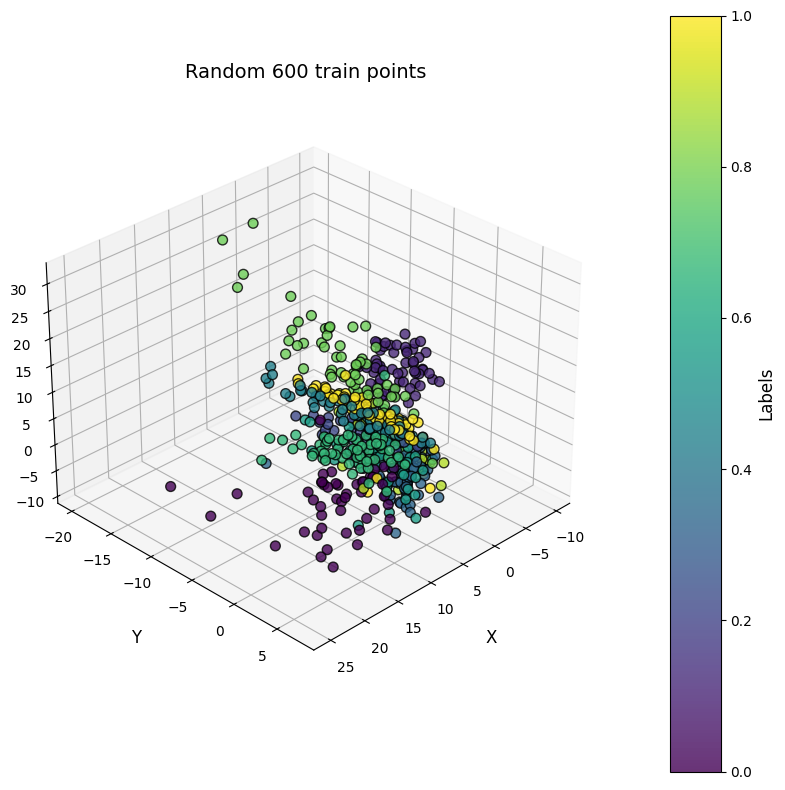

In [25]:

lbTr = lbTr.astype(int)
lbTe = lbTe.astype(int)

# Define a color map for labels
colors = plt.cm.viridis  # Adjust this based on your colormap

# Create first figure for Training Points
fig1 = plt.figure(figsize=(8, 8))

# Plot Training Points
ax1 = fig1.add_subplot(111, projection='3d')

# Select 1000 random points from the training data
num_points_to_plot = int(Trsize*0.01)
random_indices = np.random.choice(coosTr.shape[0], size=num_points_to_plot, replace=False)

# Subset the points and labels using the random indices
coosTr_subset = coosTr[random_indices]
lbTr_subset = lbTr[random_indices]

# Normalize training labels
norm_labels_tr = (lbTr_subset - lbTr_subset.min()) / (lbTr_subset.max() - lbTr_subset.min())  # Normalize the subset

# Plot the random subset of points
sc1 = ax1.scatter(coosTr_subset[:, 0], coosTr_subset[:, 1], coosTr_subset[:, 2],
                  c=norm_labels_tr, cmap='viridis', alpha=0.8, s=50, edgecolor='k')

ax1.set_title(f"Random {num_points_to_plot} train points", fontsize=14, pad=20)
ax1.set_xlabel('X', labelpad=15, fontsize=12)
ax1.set_ylabel('Y', labelpad=15, fontsize=12)
ax1.set_zlabel('Z', labelpad=15, fontsize=12)
ax1.view_init(elev=30, azim=45)

# Add color bar for Training Points
cbar1 = plt.colorbar(sc1, ax=ax1, pad=0.1, aspect=15)
cbar1.set_label('Labels', fontsize=12)

# Adjust layout for Training Points
plt.tight_layout()

# Show the plot
plt.show()


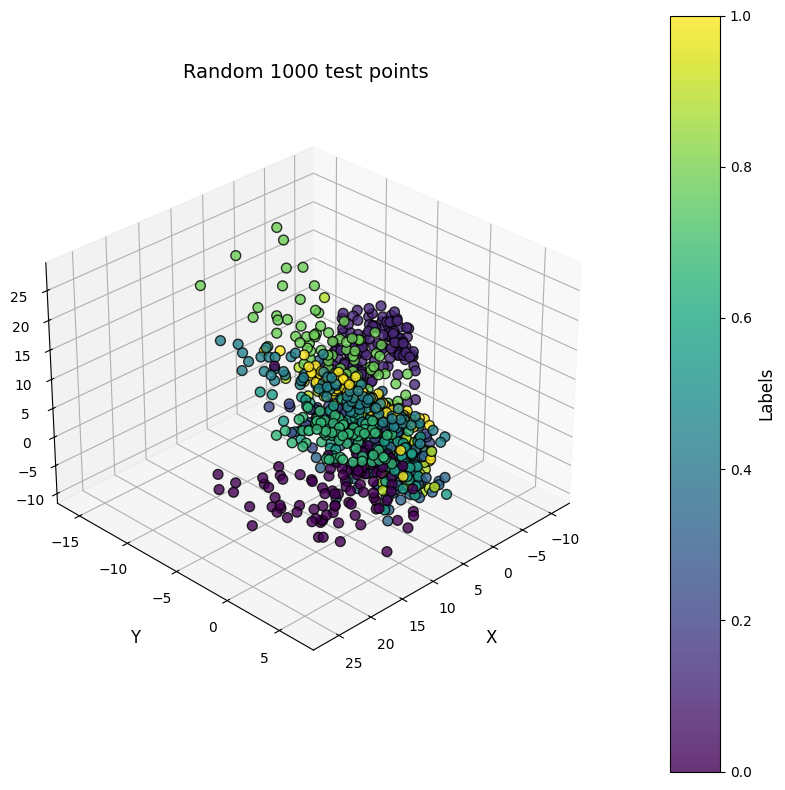

In [26]:
# Ensure labels are integers for proper color mapping
lbTe = lbTe.astype(int)

# Create second figure for Test Points
fig2 = plt.figure(figsize=(8, 8))

# Plot Test Points
ax2 = fig2.add_subplot(111, projection='3d')

# Select 1000 random points from the test data
num_points_to_plot = int(Tesize*0.1)
random_indices = np.random.choice(coosTe.shape[0], size=num_points_to_plot, replace=False)

# Subset the points and labels using the random indices
coosTe_subset = coosTe[random_indices]
lbTe_subset = lbTe[random_indices]

# Normalize test labels
norm_labels_te = (lbTe_subset - lbTe_subset.min()) / (lbTe_subset.max() - lbTe_subset.min())  # Normalize the subset

# Plot the random subset of points
sc2 = ax2.scatter(coosTe_subset[:, 0], coosTe_subset[:, 1], coosTe_subset[:, 2],
                  c=norm_labels_te, cmap='viridis', alpha=0.8, s=50, edgecolor='k')

ax2.set_title(f"Random {num_points_to_plot} test points", fontsize=14, pad=20)
ax2.set_xlabel('X', labelpad=15, fontsize=12)
ax2.set_ylabel('Y', labelpad=15, fontsize=12)
ax2.set_zlabel('Z', labelpad=15, fontsize=12)
ax2.view_init(elev=30, azim=45)

# Add color bar for Test Points
cbar2 = plt.colorbar(sc2, ax=ax2, pad=0.1, aspect=15)
cbar2.set_label('Labels', fontsize=12)

# Adjust layout for Test Points
plt.tight_layout()

# Show the second plot (Test Points)
plt.show()


Στο παραπάνω σχήμα παρουσιάζεται η απεικόνιση των δεδομένων του training set και του test set στον τρισδιάστατο χώρο του latent space.

 Παρατηρούμε ότι τα σημεία και από τα δύο σύνολα κατανέμονται σε παρόμοιο χωρικό εύρος και παρουσιάζουν παρόμοια μορφολογία κατανομής, σχηματίζοντας ένα επιμήκες νέφος σημείων με αντίστοιχο προσανατολισμό και πυκνότητες.

 Επιπλέον, η χρωματική κωδικοποίηση των labels αποκαλύπτει ότι οι ίδιες κατηγορίες κατανέμονται σε αντίστοιχες περιοχές και στα δύο σύνολα, χωρίς να εμφανίζονται νέες περιοχές στο test set ή να απουσιάζουν περιοχές που υπάρχουν στο training set.

  Μικρές διαφοροποιήσεις, όπως η ύπαρξη λίγων ακραίων σημείων στο test set, αποδίδονται στον μεγαλύτερο αριθμό δειγμάτων και είναι αναμενόμενες.

Συνολικά, τα αποτελέσματα δείχνουν ότι η κατανομή των απεικονίσεων στο latent space παραμένει συνεπής μεταξύ training και test set, γεγονός που υποδηλώνει ότι το μοντέλο έχει μάθει μια σταθερή και γενικεύσιμη αναπαράσταση των δεδομένων και δεν παρουσιάζει ενδείξεις υπερπροσαρμογής σε επίπεδο latent space.

Συνεπώς, τα βασικά χαρακτηριστικά της κατανομής των απεικονίσεων στο latent space διατηρούνται και στα δύο σύνολα δεδομένων


Γ

Να χρησιμοποιήσετε τον κλάδο αποκωδικοποίησης του εκπαιδευμένου autoencoder ώστε να
δημιουργήσετε εικόνες ξεκινώντας από τυχαία σημεία του latent space. Εξερευνήστε το latent
space δοκιμάζοντας διάφορα σημεία του χώρου και παρατηρώντας τις εικόνες που
παράγονται. Αντιστοιχούν όλες οι περιοχές του latentspace σε πραγματικά ψηφία? Σχολιάστε
τα ευρήματά σας παραθέτοντας παραδείγματα εικόνων.

In [27]:
# Function for testing the autoencoder and visualizing the images
def test_autoencoder_plot_images(model: torch.nn.Module, input_size: int, latent_size: int, latent_space_points: np.ndarray):

  model.eval() # Set evaluation mode

  with torch.inference_mode(): # Deactivate gradient tracking
    latent_space_points_tensor = torch.tensor(latent_space_points, dtype=torch.float32).to(device)
    generated_images = model.decoder(latent_space_points_tensor).cpu().numpy() # Generated image, 28 x 28

    # Visualize the original, encoded and reconstructed images
    plt.figure(figsize=(12, 3))

    # Latent representation
    plt.subplot(1, 3, 2)
    plt.imshow(latent_space_points.reshape(-1, 1), cmap='hot')  # Displaying latent vector as colors
    plt.title('Latent Space Input')
    plt.axis('off')

    # Generated images
    plt.subplot(1, 3, 3)
    plt.imshow(generated_images.reshape(input_size, input_size), cmap='gray')
    plt.title('Generated')
    plt.axis('off')

    plt.show()

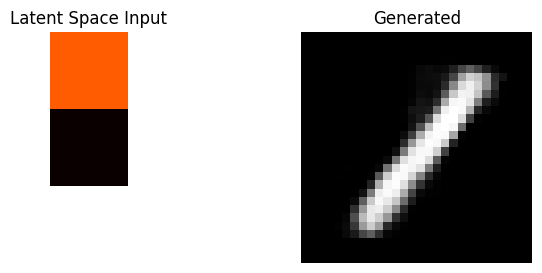

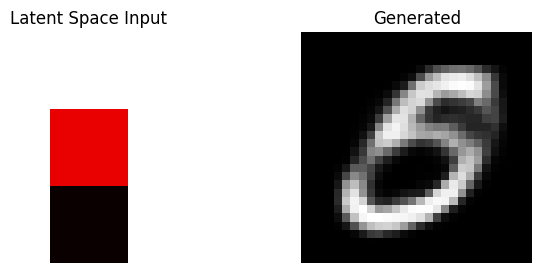

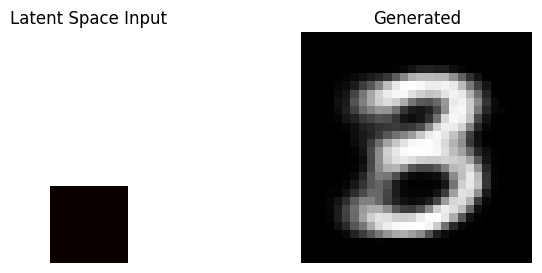

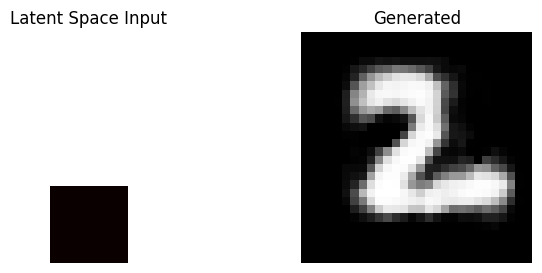

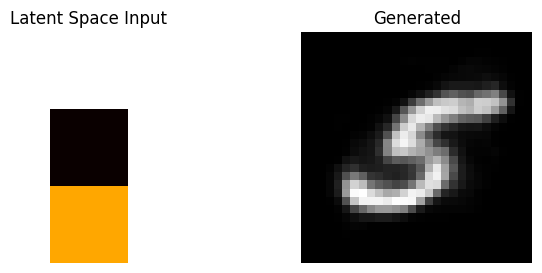

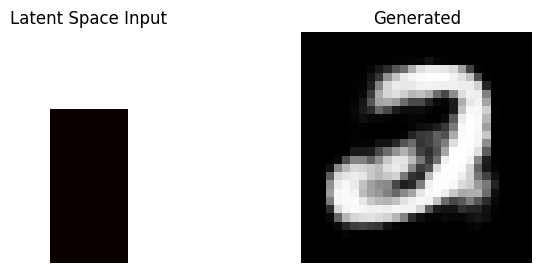

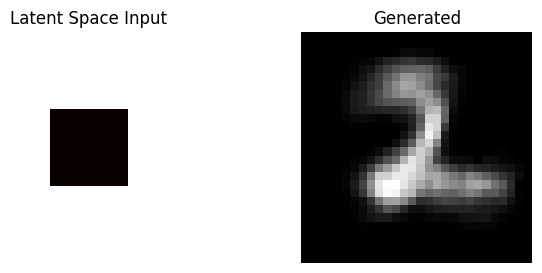

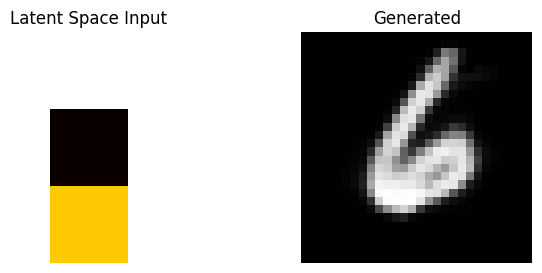

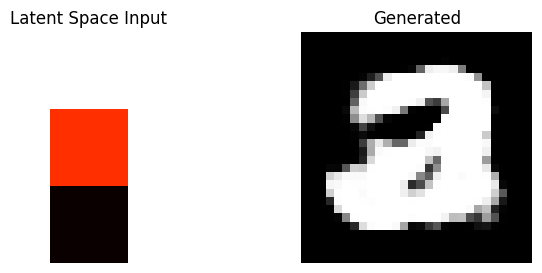

In [28]:
latent_space_points = np.array([-5, -10, 0]) # 0
test_autoencoder_plot_images(model_V1, input_size, latent_size_2, latent_space_points)

latent_space_points = np.array([10, 0, -5]) # 1
test_autoencoder_plot_images(model_V1, input_size, latent_size_2, latent_space_points)

latent_space_points = np.array([2, 2, -5]) # 2
test_autoencoder_plot_images(model_V1, input_size, latent_size_2, latent_space_points)

latent_space_points = np.array([-3, -3, -5]) # 3
test_autoencoder_plot_images(model_V1, input_size, latent_size_2, latent_space_points)

latent_space_points = np.array([5, -8, 0]) # 4
test_autoencoder_plot_images(model_V1, input_size, latent_size_2, latent_space_points)

latent_space_points = np.array([4, -9, -9]) # 5
test_autoencoder_plot_images(model_V1, input_size, latent_size_2, latent_space_points)

latent_space_points = np.array([-2, -3, -2]) # 6
test_autoencoder_plot_images(model_V1, input_size, latent_size_2, latent_space_points)

latent_space_points = np.array([10, -5, 5]) # 7
test_autoencoder_plot_images(model_V1, input_size, latent_size_2, latent_space_points)

latent_space_points = np.array([3, -10, -20]) # 8
test_autoencoder_plot_images(model_V1, input_size, latent_size_2, latent_space_points)

latent_space_points = np.array([9, -8, -3]) # 9

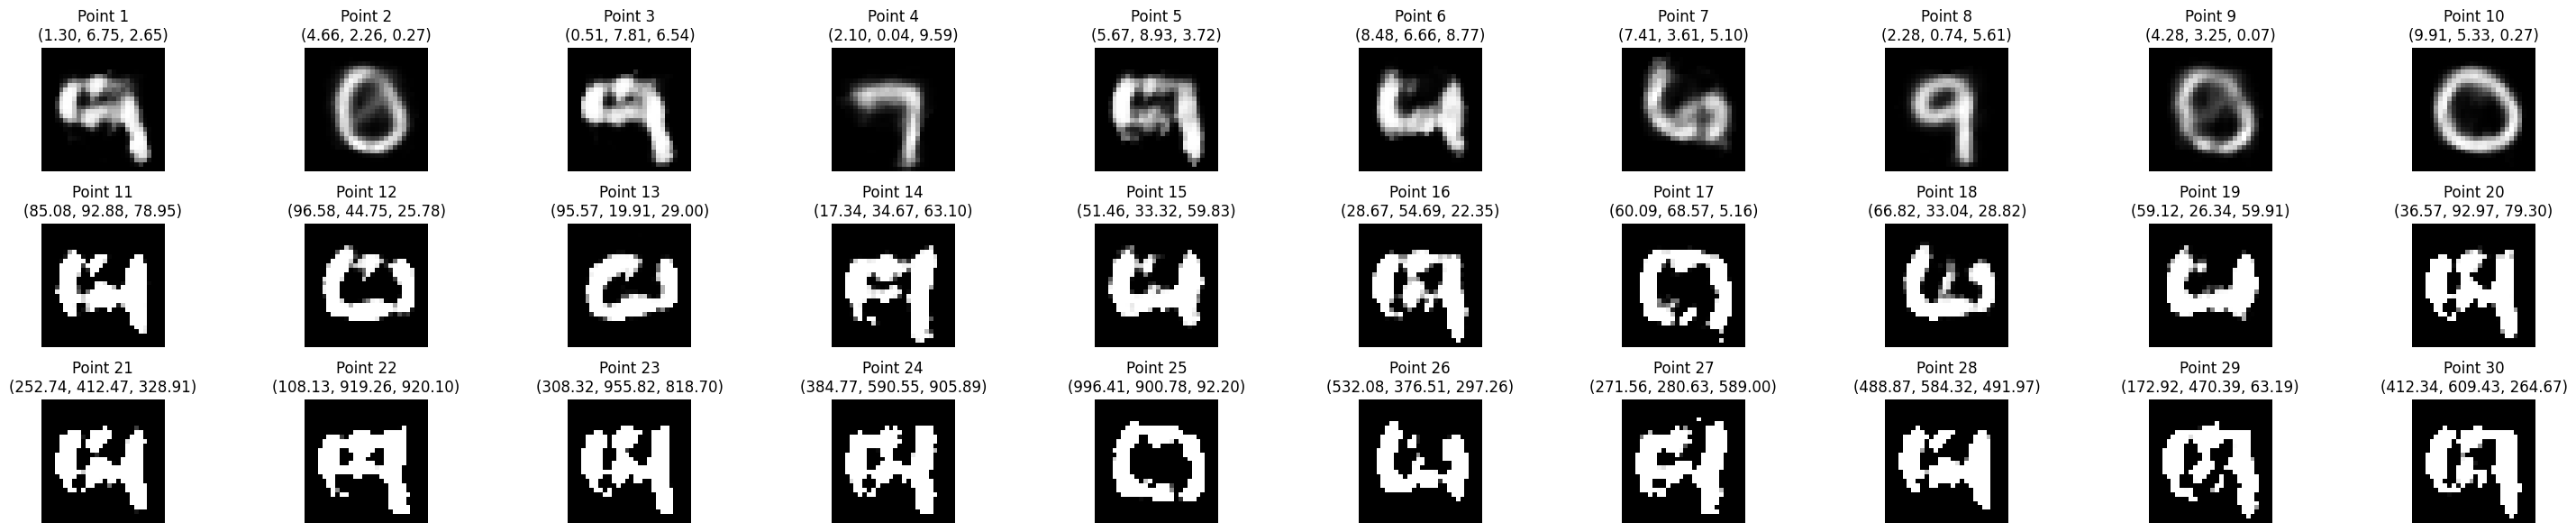

In [30]:
import matplotlib.pyplot as plt

torch.manual_seed(1204)

latent_space_points = torch.rand(30,3)
latent_space_points[0:10,:] = 10*latent_space_points[0:10,:]
latent_space_points[10:20,:] = 100*latent_space_points[10:20,:]
latent_space_points[20:30,:] = 1000*latent_space_points[20:30,:]

# Decode the generated latent points and plot the corresponding images
fig, axes = plt.subplots(3, 10, figsize=(30, 6))  # 2 rows and 10 columns for the plot
axes = axes.flatten()  # Flatten the axes array for easy indexing

with torch.no_grad():  # No need to compute gradients for this part
    for i, latent_vector in enumerate(latent_space_points):
        # Decode the latent vector to get the reconstructed image
        decoded_image = model_V1.decoder(latent_vector.unsqueeze(0))  # (1, 784)

        # Reshape the decoded image to 28x28
        decoded_image = decoded_image.view(28, 28)

        # Plot the image
        axes[i].imshow(decoded_image.cpu().numpy(), cmap='gray')
        axes[i].axis('off')

        # Extract the coordinates of the current latent vector
        coords = latent_vector.cpu().numpy()  # Get the coordinates as a NumPy array
        # Show the coordinates in the title of each plot
        axes[i].set_title(f"Point {i+1}\n({coords[0]:.2f}, {coords[1]:.2f}, {coords[2]:.2f})")

plt.tight_layout()
plt.show()

Για την εξερεύνηση του latent space χρησιμοποιήθηκε ο αποκωδικοποιητής του εκπαιδευμένου autoencoder, ο οποίος δέχθηκε ως είσοδο τυχαία σημεία από τον χώρο των λανθανουσών μεταβλητών. Για κάθε σημείο δημιουργήθηκε η αντίστοιχη εικόνα και συγκρίθηκε οπτικά με τα πραγματικά ψηφία του dataset.

Παρατηρείται ότι για σημεία τα οποία βρίσκονται κοντά στην «πυκνή» περιοχή του latent space (δηλαδή σε περιοχές όπου κατά την εκπαίδευση υπήρχαν πολλές απεικονίσεις του training set), ο αποκωδικοποιητής παράγει σχετικά καθαρές, αναγνωρίσιμες εικόνες ψηφίων. Τα παραγόμενα ψηφία έχουν συνεχείς γραμμές και μορφολογία παρόμοια με αυτήν των πραγματικών δεδομένων, γεγονός που υποδεικνύει ότι το μοντέλο έχει μάθει μια ουσιαστική αναπαράσταση της κατανομής των ψηφίων.

Αντίθετα, όταν επιλέγονται σημεία που βρίσκονται «μακριά» από τις περιοχές όπου κατανέμονται τα πραγματικά embeddings (π.χ. πολύ μεγάλες τιμές στις συντεταγμένες του latent space), οι παραγόμενες εικόνες δεν αντιστοιχούν σε πραγματικά γράμματα ή ψηφία. Σε αυτές τις περιπτώσεις εμφανίζονται θολές, παραμορφωμένες ή εντελώς μη ρεαλιστικές μορφές, χωρίς σαφή ψηφιακή δομή. Αυτό συμβαίνει επειδή το μοντέλο δεν έχει «δει» τέτοιες περιοχές κατά την εκπαίδευση και, επομένως, δεν μπορεί να παράγει έγκυρες αναπαραστάσεις.

Συμπερασματικά, δεν αντιστοιχούν όλες οι περιοχές του latent space σε πραγματικά ψηφία. Μόνο η περιοχή όπου συγκεντρώνονται τα embeddings των πραγματικών δεδομένων (training manifold) οδηγεί σε ρεαλιστικές ανακατασκευές. Περιοχές εκτός αυτής παράγουν παραμορφωμένες ή άκυρες εικόνες, επιβεβαιώνοντας ότι το μοντέλο έχει μάθει μια συγκεκριμένη υποκείμενη κατανομή και δεν γενικεύει πέρα από αυτή.